## Mean property trends of currents with confidence intervals. Also box plots seperated by CCS region

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Point, MultiPoint, GeometryCollection, MultiLineString
from scipy import stats
from pyproj import Geod
from shapely.ops import unary_union
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, UnivariateSpline
from cartopy import crs
from cartopy.feature import NaturalEarthFeature

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [7]:
# Helper: interpolate 1D array ignoring NaNs
def interpolate_nan(x, y):
    mask = np.isfinite(y)
    f = interp1d(x[mask], y[mask], kind='linear', bounds_error=False, fill_value="extrapolate")
    return f(x)

def custom_round(x, base=250):
    return int(base * round(float(x)/base))

## Loading Data and Indicators

In [ ]:
obs = pd.read_csv(IOPATH)
for col, count in obs.count().items():
    print(f"{col}: {count} non-NaN values")

Unnamed: 0.1: 1378653 non-NaN values
Unnamed: 0: 1378653 non-NaN values
time: 1378653 non-NaN values
longitude (degrees_east): 1378653 non-NaN values
latitude (degrees_north): 1378653 non-NaN values
depth (m): 1378653 non-NaN values
pressure (dbar): 1378653 non-NaN values
temperature (degC): 1135852 non-NaN values
salinity (g kg-1): 1352245 non-NaN values
DO (umol kg-1): 976428 non-NaN values
NO3 (uM): 357487 non-NaN values
NO2 (uM): 301433 non-NaN values
NH4 (uM): 5217 non-NaN values
PO4 (uM): 357732 non-NaN values
SiO4 (uM): 58357 non-NaN values
Chl (mg m-3): 39366 non-NaN values
TA (uM): 8275 non-NaN values
DIC (uM): 8263 non-NaN values
Carbonate: 2371 non-NaN values
Aragonite: 7136 non-NaN values
Calcite: 7136 non-NaN values
Cd (nmol kg-1): 895 non-NaN values
Co (nmol kg-1): 872 non-NaN values
Cu (nmol kg-1): 1068 non-NaN values
Fe (nmol kg-1): 1061 non-NaN values
Mn (nmol kg-1): 875 non-NaN values
Ni (nmol kg-1): 876 non-NaN values
Zn (nmol kg-1): 874 non-NaN values
source: 137865

In [4]:
# add year column
obs['year'] = [int(obs.time[i][:4]) for i in range(len(obs))]

In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

In [3]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/ghoeven/MOAD/Data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index')
enso['month'] = enso['month'].astype(int)
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/ghoeven/MOAD/Data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/ghoeven/MOAD/Data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


## Figures

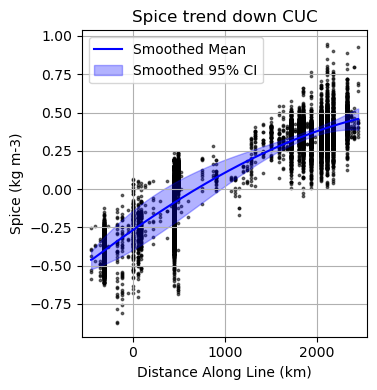

In [ ]:
x = obs_cuc['dist']
y = obs_cuc['spice']
######

# Group by x
df = pd.DataFrame({'x': x, 'y': y})
grouped = df.groupby('x')

x_unique = grouped.mean().index.values
y_mean = grouped.mean()['y'].values
y_std = grouped.std()['y'].values
n = grouped.size().values

# Compute 95% CI
t_crit = stats.t.ppf(0.975, df=n-1)
ci = t_crit * y_std / np.sqrt(n)
lower = y_mean - ci
upper = y_mean + ci

# Interpolation points
x_fine = np.linspace(min(x_unique), max(x_unique), 400)

# Impute missing values
y_mean = interpolate_nan(x_unique, y_mean)
lower = interpolate_nan(x_unique, lower)
upper = interpolate_nan(x_unique, upper)

# 1. Use UnivariateSpline with moderate s
mean_spline = UnivariateSpline(x_unique, y_mean, s=10)
lower_spline = UnivariateSpline(x_unique, lower, s=10)
upper_spline = UnivariateSpline(x_unique, upper, s=10)

# 2. Evaluate and apply gaussian smoothing
y_mean_smooth = gaussian_filter1d(mean_spline(x_fine), sigma=2)
y_lower_smooth = gaussian_filter1d(lower_spline(x_fine), sigma=2)
y_upper_smooth = gaussian_filter1d(upper_spline(x_fine), sigma=2)


#######
fig, ax = plt.subplots(1,1, figsize=(4, 4))
# Plot
ax.scatter(x, y, s=3, alpha=0.55, c='k')

plt.plot(x_fine, y_mean_smooth, label='Smoothed Mean', color='blue')
plt.fill_between(x_fine, y_lower_smooth, y_upper_smooth,
                 color='blue', alpha=0.3, label='Smoothed 95% CI')
ax.set_xlim([min(x)-100, max(x)+100])
ax.set_xlabel('Distance Along Line (km)')
ax.set_ylabel('Spice (kg m-3)')
ax.set_title('Spice trend down CUC')
ax.grid()
ax.legend()
plt.tight_layout()

In [24]:

def plot_property_NStrend(d_out, var_string, current_string, subplot_pos):
    """
    Plot Property Trends up and down the north-south line with origin at bifurcation of California Current
    
    Parameters
    ----------
    d_out : array
        distances along line
    var_string : string
        string like 'temperature (degC)' to select property
    current_string : string
        string for one of three currents - either 'CC', 'CUC, 'Shelf'
    subplot_pos : int or tuple
        subplot position
    
    Returns
    -------
    None
        just plots figure
    """

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='shelf':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 

    ylim_dict = {'spice':[-2,2], 'temperature (degC)': [5,20], 'salinity (g kg-1)':[30,35]}

    
    x = d_out
    y = obs_used[var_string]
    idx = np.isfinite(x) & np.isfinite(y)
    
    # Group by x
    df = pd.DataFrame({'x': x[idx], 'y': y[idx]})
    df['x_bin'] = df['x'].apply(lambda x: custom_round(x, base=225)) # so that mean and CI calculated on bins along distance line 
    #(important for tracers with more scarce obs)

    grouped = df.groupby('x_bin')

    x_unique = grouped.mean().index.values
    y_mean = grouped.mean()['y'].values
    y_std = grouped.std()['y'].values
    n = grouped.size().values
    
    # Compute 95% CI
    t_crit = stats.t.ppf(0.975, df=n-1)
    ci = t_crit * y_std / np.sqrt(n)

    lower = y_mean - ci
    upper = y_mean + ci
    
    # if (current_string=='Shelf') & (var_string=='DO (umol kg-1)'):
    #     print(lower, upper)
        
    # Interpolation points
    x_fine = np.linspace(min(x_unique), max(x_unique), 400)
    
    # Impute missing values
    y_mean = interpolate_nan(x_unique, y_mean)
    lower = interpolate_nan(x_unique, lower)
    upper = interpolate_nan(x_unique, upper)

    # if (current_string=='Shelf') & (var_string=='DO (umol kg-1)'):
    #     print(min(lower), max(upper))
    
    # Use UnivariateSpline with moderate s (more smooth, less wiggly)
    mean_spline = UnivariateSpline(x_unique, y_mean, s=4) # s is the smoothing factor
    lower_spline = UnivariateSpline(x_unique, lower, s=4)
    upper_spline = UnivariateSpline(x_unique, upper, s=4)

    # if (current_string=='Shelf') & (var_string=='DO (umol kg-1)'):
    #     print(min(lower_spline(x_fine)), max(upper_spline(x_fine)))
    
    # Evaluate and apply gaussian smoothing
    y_mean_smooth = gaussian_filter1d(mean_spline(x_fine), sigma=2)
    y_lower_smooth = gaussian_filter1d(lower_spline(x_fine), sigma=2)
    y_upper_smooth = gaussian_filter1d(upper_spline(x_fine), sigma=2)

    # Plot
    ax[subplot_pos].scatter(x[idx],y[idx], s=3, alpha=0.55, c='k')
    ax[subplot_pos].plot(x_fine, y_mean_smooth, label='Smoothed Mean', color='blue')
    ax[subplot_pos].fill_between(x_fine, y_lower_smooth, y_upper_smooth,
                     color='blue', alpha=0.3, label='Smoothed 95% CI')

    if var_string in list(ylim_dict.keys()):
        ax[subplot_pos].set_ylim(ylim_dict[var_string])
    
    ax[subplot_pos].set_xlim([min(x)-100, max(x)+100])
    ax[subplot_pos].set_xlabel('Distance Along Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Spice (kg m-3)')
    else:
        ax[subplot_pos].set_ylabel(var_string)
    
    ax[subplot_pos].set_title(f'{var_string} trend down {current_string}')
    ax[subplot_pos].grid()
    ax[subplot_pos].legend()
    
    return None


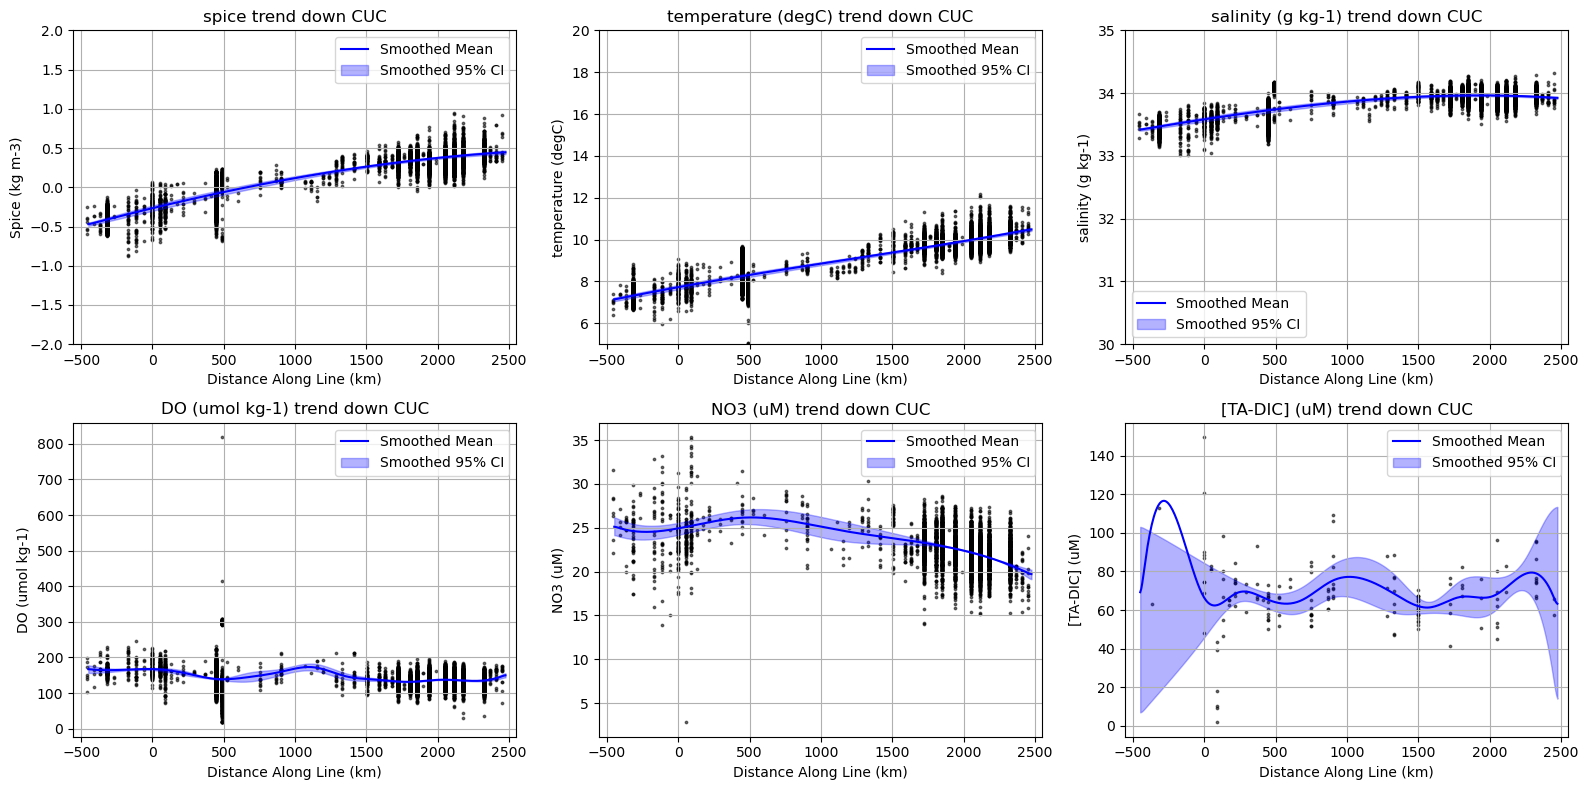

In [21]:
x = obs_cuc['dist']
current = 'CUC'
fig, ax = plt.subplots(2,3, figsize=(16, 8))

plot_property_NStrend(x, 'spice', current, (0,0))
plot_property_NStrend(x, 'temperature (degC)', current, (0,1))
plot_property_NStrend(x, 'salinity (g kg-1)', current, (0,2))
plot_property_NStrend(x, 'DO (umol kg-1)', current, (1,0))
plot_property_NStrend(x, 'NO3 (uM)', current, (1,1))
plot_property_NStrend(x, '[TA-DIC] (uM)', current, (1,2))

plt.tight_layout()

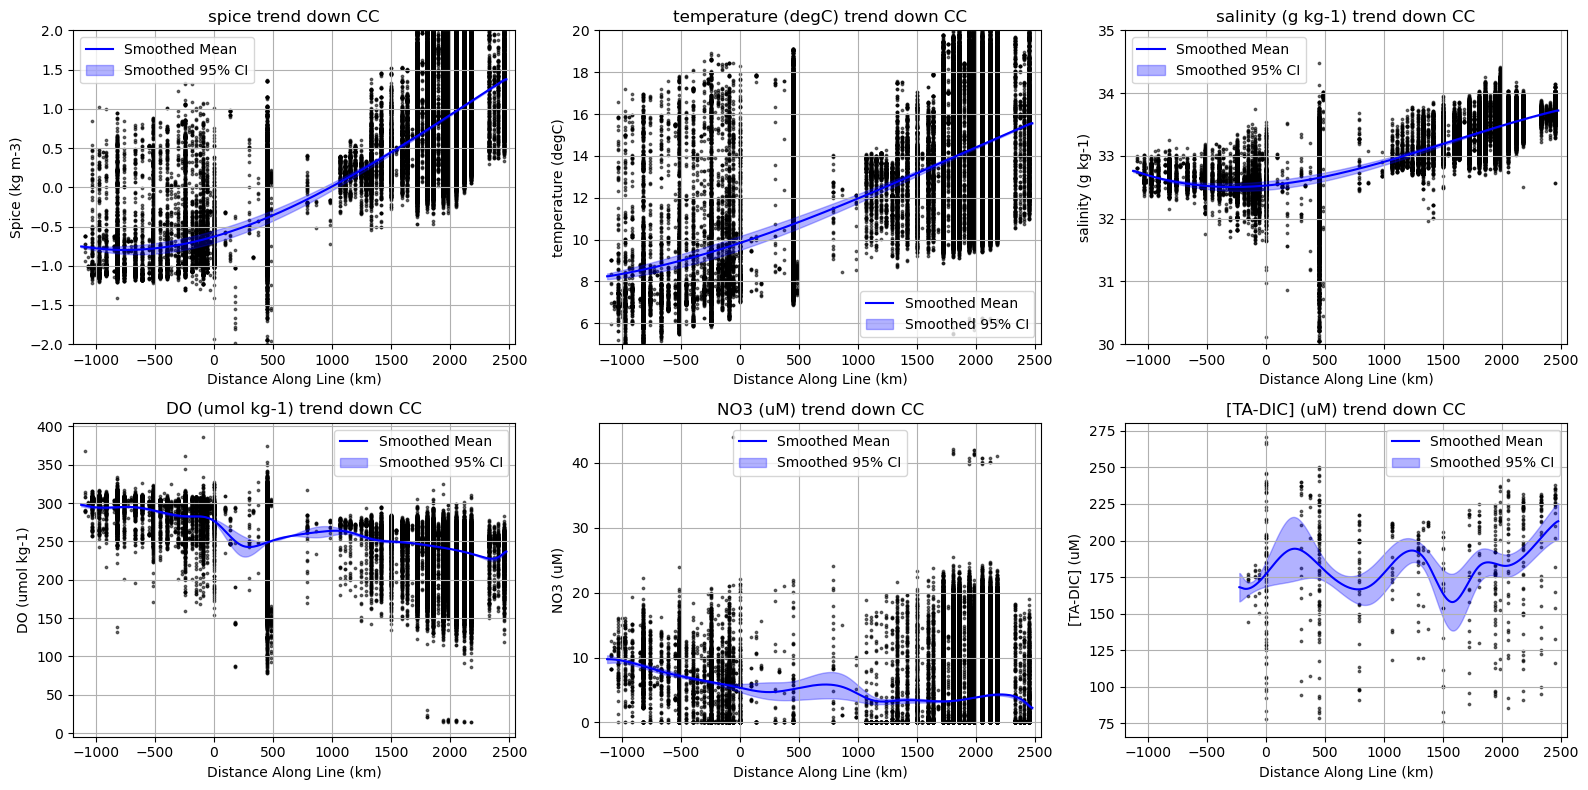

In [22]:
x = obs_cc['dist']
current = 'CC'
fig, ax = plt.subplots(2,3, figsize=(16, 8))

plot_property_NStrend(x, 'spice', current, (0,0))
plot_property_NStrend(x, 'temperature (degC)', current, (0,1))
plot_property_NStrend(x, 'salinity (g kg-1)', current, (0,2))
plot_property_NStrend(x, 'DO (umol kg-1)', current, (1,0))
plot_property_NStrend(x, 'NO3 (uM)', current, (1,1))
plot_property_NStrend(x, '[TA-DIC] (uM)', current, (1,2))

plt.tight_layout()

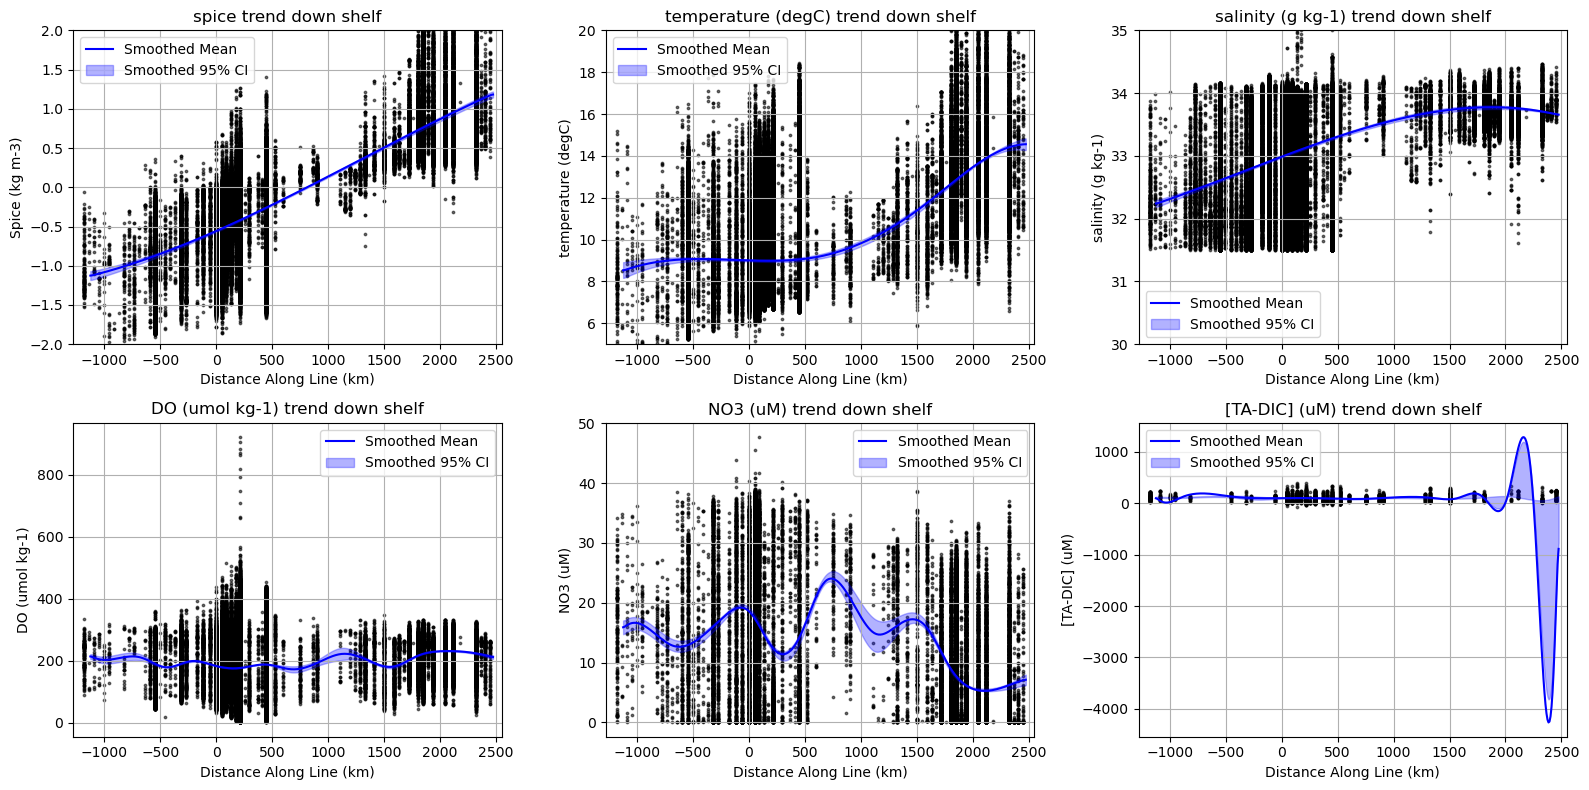

In [25]:
x = obs_shelf['dist']
current = 'shelf'
fig, ax = plt.subplots(2,3, figsize=(16, 8))

plot_property_NStrend(x, 'spice', current, (0,0))
plot_property_NStrend(x, 'temperature (degC)', current, (0,1))
plot_property_NStrend(x, 'salinity (g kg-1)', current, (0,2))
plot_property_NStrend(x, 'DO (umol kg-1)', current, (1,0))
plot_property_NStrend(x, 'NO3 (uM)', current, (1,1))
plot_property_NStrend(x, '[TA-DIC] (uM)', current, (1,2))

plt.tight_layout()

## Box and Whisker Plots

In [26]:
# from checkley and barth 2009 - "define the northern, central, and southern CCS, 
# with divisions at Cape Mendocino and Point Conception, respectively"
# Cape Mendocino = 40.44 N
# Point conception = 35.45 N

obs_northCCS = obs[obs['latitude (degrees_north)'] > 40.44]
obs_centerCCS = obs[(obs['latitude (degrees_north)'] <= 40.44) & (obs['latitude (degrees_north)'] > 35.45)]
obs_southCCS = obs[obs['latitude (degrees_north)'] <= 35.45]

In [31]:
def plot_property_boxwhisker(var_string, current_string, subplot_pos):
    """
    Plot Property Trends up and down the north-south line with origin at bifurcation of California Current
    
    Parameters
    ----------
    var_string : string
        string like 'temperature (degC)' to select property
    current_string : string
        string for one of three currents - either 'CC', 'CUC, 'Shelf'
    subplot_pos : int or tuple
        subplot position
    
    Returns
    -------
    None
        just plots figure
    """
    obs_northCCS_current = obs_northCCS[obs_northCCS.current == current_string]
    obs_centerCCS_current = obs_centerCCS[obs_centerCCS.current == current_string] 
    obs_southCCS_current = obs_southCCS[obs_southCCS.current == current_string] 
    data = [obs_northCCS_current[var_string].dropna(), obs_centerCCS_current[var_string].dropna(), obs_southCCS_current[var_string].dropna()]
    labels = ['Northern', 'Central', 'Southern']
    
    # Plot boxplot
    ax[subplot_pos].boxplot(data, 
                            patch_artist=True, 
                            flierprops=dict(markerfacecolor='k', marker='o', markersize=2, alpha=0.5), 
                            medianprops=dict(color='k', linewidth=2), 
                            boxprops=dict(facecolor='lightblue'))
    ax[subplot_pos].set_xticklabels(labels)
    
    # Plot mean points
    means = [d.mean() for d in data]
    ax[subplot_pos].scatter([1, 2, 3], means, color='red', marker='D', label='Regional Means', s=10, alpha=0.7, zorder=6)
    
    ax[subplot_pos].set_xlabel('CCS Regions')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Spice (kg m-3)')
    else:
        ax[subplot_pos].set_ylabel(var_string)
    
    ax[subplot_pos].set_title(f'{var_string} across the {current_string}')
    ax[subplot_pos].legend()
    return None

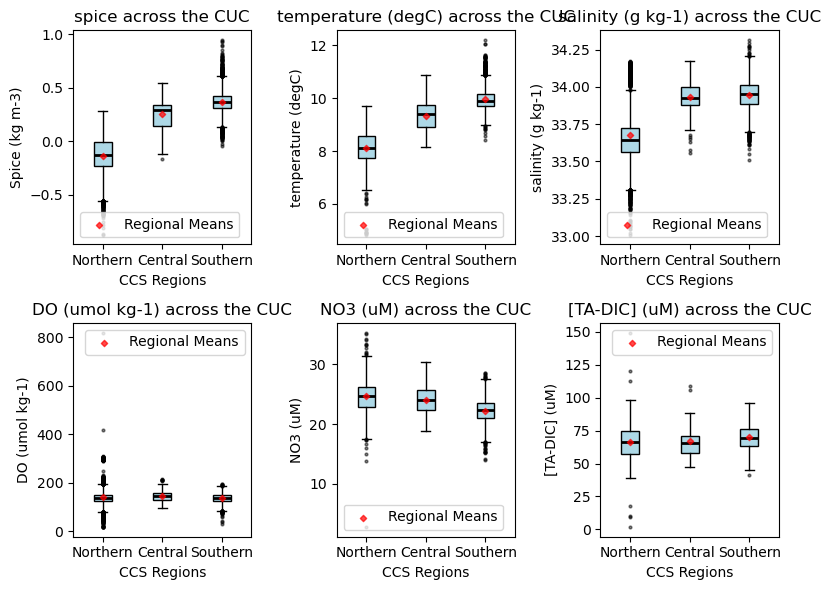

In [ ]:
current = 'CUC'
fig, ax = plt.subplots(2,3, figsize=(8, 6))
plot_property_boxwhisker('spice', current, (0,0))
plot_property_boxwhisker('temperature (degC)', current, (0,1))
plot_property_boxwhisker('salinity (g kg-1)', current, (0,2))
plot_property_boxwhisker('DO (umol kg-1)', current, (1,0))
plot_property_boxwhisker('NO3 (uM)', current, (1,1))
plot_property_boxwhisker('[TA-DIC] (uM)', current, (1,2))
plt.tight_layout()

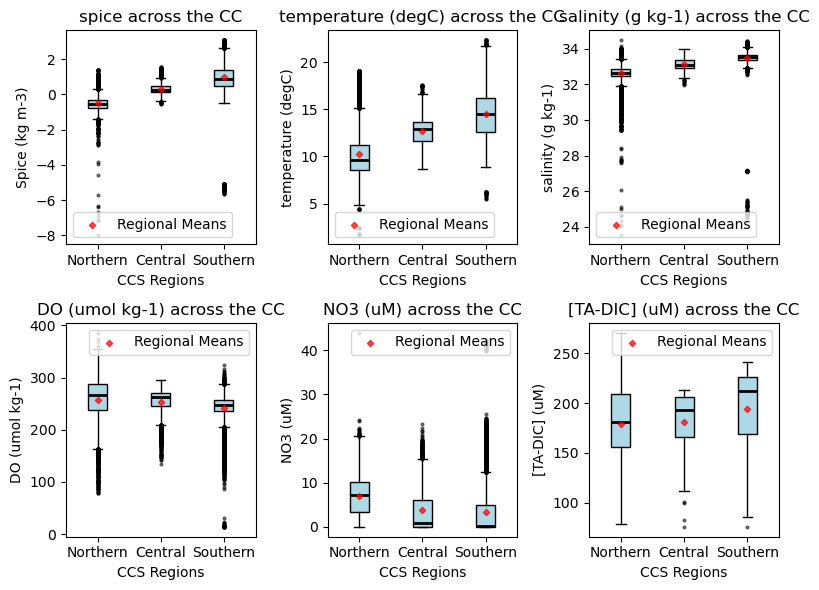

In [37]:
current = 'CC'
fig, ax = plt.subplots(2,3, figsize=(8, 6))
plot_property_boxwhisker('spice', current, (0,0))
plot_property_boxwhisker('temperature (degC)', current, (0,1))
plot_property_boxwhisker('salinity (g kg-1)', current, (0,2))
plot_property_boxwhisker('DO (umol kg-1)', current, (1,0))
plot_property_boxwhisker('NO3 (uM)', current, (1,1))
plot_property_boxwhisker('[TA-DIC] (uM)', current, (1,2))
plt.tight_layout()

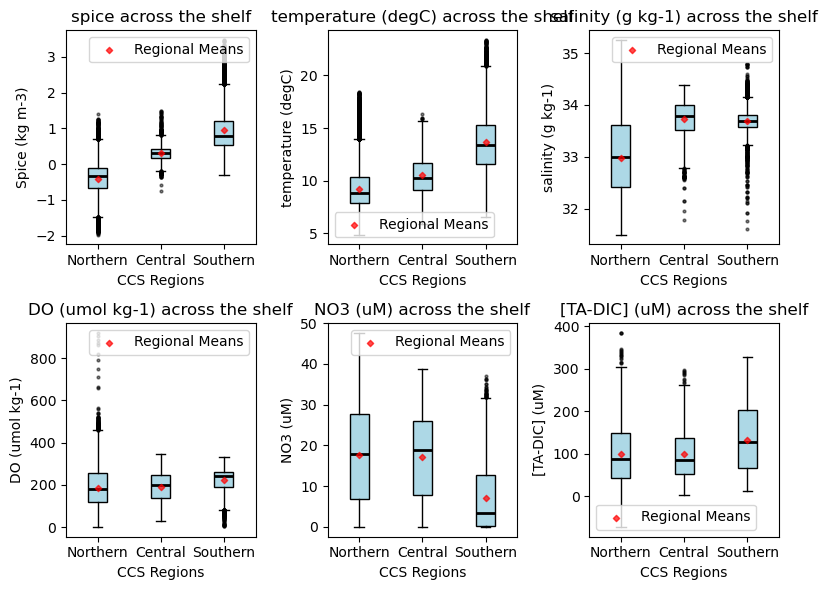

In [38]:
current = 'shelf'
fig, ax = plt.subplots(2,3, figsize=(8, 6))
plot_property_boxwhisker('spice', current, (0,0))
plot_property_boxwhisker('temperature (degC)', current, (0,1))
plot_property_boxwhisker('salinity (g kg-1)', current, (0,2))
plot_property_boxwhisker('DO (umol kg-1)', current, (1,0))
plot_property_boxwhisker('NO3 (uM)', current, (1,1))
plot_property_boxwhisker('[TA-DIC] (uM)', current, (1,2))
plt.tight_layout()